In [1]:
import cv2
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import tflearn

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist_data_folder='../assets'
mnist=input_data.read_data_sets(mnist_data_folder, one_hot=True)

Extracting ../assets\train-images-idx3-ubyte.gz
Extracting ../assets\train-labels-idx1-ubyte.gz
Extracting ../assets\t10k-images-idx3-ubyte.gz
Extracting ../assets\t10k-labels-idx1-ubyte.gz


In [3]:
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
trX = trX.reshape(-1, 28, 28, 1)  # 将每张图片用一个28x28的矩阵表示,(55000,28,28,1)
trX.shape, trX[1].shape

((55000, 28, 28, 1), (28, 28, 1))

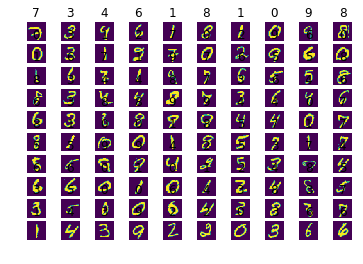

In [4]:
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(trX[i].reshape(28, 28))
    plt.title(np.argmax(trY[i]))
    plt.axis('off')

In [6]:
def conv_net(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    #第一个卷积层:padding=SAME,保证输出的feature map与输入矩阵的大小相同
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    #max_pooling,窗口大小为2x2
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    #dropout:每个神经元有p_keep_conv的概率以1/p_keep_conv的比例进行归一化,有(1-p_keep_conv)的概率置为0
    l1 = tf.nn.dropout(l1, p_keep_conv)

    #第二个卷积层
    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)

    #第三个卷积层
    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    #将所有的feature map合并成一个2048维向量
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)
    #后面两层为全连接层
    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)
    pyx = tf.matmul(l4, w_o)
    
    return pyx

In [7]:
#初始化参数
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [8]:
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 17])

In [9]:
w = init_weights([3, 3, 1, 32])       # 第一层卷积核大小为3x3,输入一张图,输出32个feature map
w2 = init_weights([3, 3, 32, 64])     # 第二层卷积核大小为3x3,输入32个feature map,输出64个feature map
w3 = init_weights([3, 3, 64, 128])    # 第三层卷积核大小为3x3,输入64个feature map,输出128个feature map
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 17])         # FC 625 inputs, 10 outputs (labels)

In [10]:
p_keep_conv = tf.placeholder("float") # 卷积层的dropout概率
p_keep_hidden = tf.placeholder("float")# 全连接层的dropout概率
py_x = conv_net(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

In [11]:
#初始化变量
# init = tf.initialize_all_variables()
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y))# 交叉熵目标函数
train_op = tf.train.AdamOptimizer(0.001, 0.9) \
            .minimize(cost)  # RMSPro算法最小化目标函数

In [14]:
#评估模型
# predict_op = tf.argmax(py_x, 1)#返回每个样本的预测结果
predict_op1 = py_x#返回每个样本的预测结果

In [50]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()  ##保存的API
saver.restore(sess,"../model/Test_CNN_Model.ckpt")  #load上一步训练的参数

INFO:tensorflow:Restoring parameters from ../model/Test_CNN_Model.ckpt
Testing Result: [8]
Testing Result: [9]


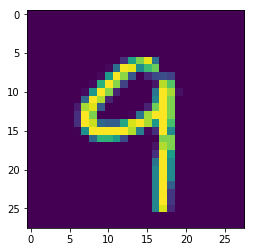

In [48]:
plt.imshow(trX[8].reshape(28, 28))

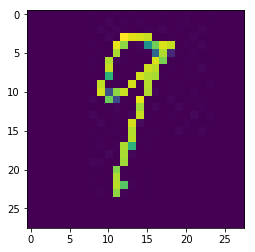

In [64]:
img = cv2.imread('../data/nums/8677.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

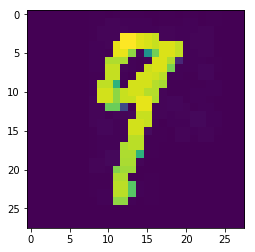

In [65]:
kernel = np.ones((2,2),np.uint8)
dilation = cv2.dilate(img,kernel,iterations = 1) 
plt.imshow(dilation)

In [66]:
pred = sess.run(predict_op, feed_dict={X: img.reshape(-1, 28, 28, 1), p_keep_conv: 1.0, p_keep_hidden: 1.0})
print("Testing Result:", pred)
pred = sess.run(predict_op, feed_dict={X: dilation.reshape(-1, 28, 28, 1), p_keep_conv: 1.0, p_keep_hidden: 1.0})
print("Testing Result:", pred)

Testing Result: [8]
Testing Result: [9]


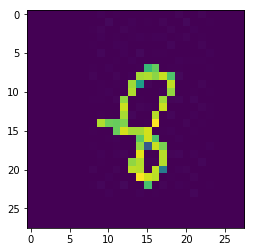

In [59]:
img = cv2.imread('../data/nums/3247.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

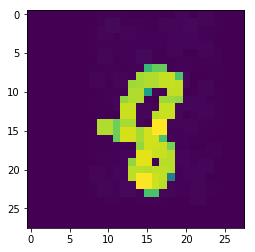

In [60]:
kernel = np.ones((2,2),np.uint8)
dilation = cv2.dilate(img,kernel,iterations = 1) 
plt.imshow(dilation)

In [62]:
pred = sess.run(predict_op, feed_dict={X: img.reshape(-1, 28, 28, 1), p_keep_conv: 1.0, p_keep_hidden: 1.0})
print("Testing Result:", pred)
pred = sess.run(predict_op, feed_dict={X: dilation.reshape(-1, 28, 28, 1), p_keep_conv: 1.0, p_keep_hidden: 1.0})
print("Testing Result:", pred)

Testing Result: [13]
Testing Result: [4]
